In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load in data
df = pd.read_csv("heart_failure_data.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory Data Analysis (EDA)

## EDA Step 1: Tabular Descriptors

In [3]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

### Attribute information:
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [4]:
# Summary statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number])
numerical_features = numerical_features.drop(["HeartDisease", "FastingBS"], axis=1)
numerical_features.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [5]:
# Summary statistics for categorical features
categorical_features = df.select_dtypes(include=[object])
categorical_features.describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# Check for null values in the dataset
df.isnull().sum()  # there are none, great [although later I find that cholesterol has null values set to 0]

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## EDA step 2: visualizing the dataset

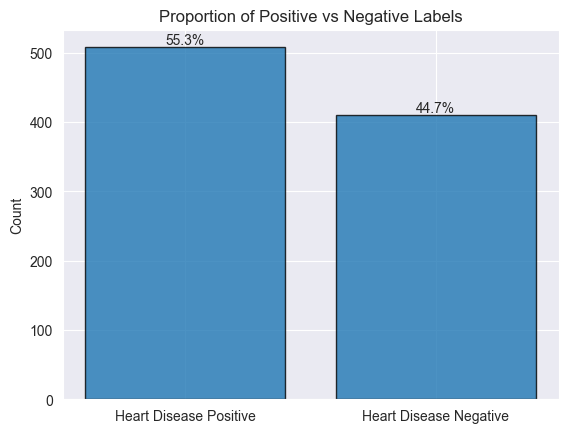

In [8]:
fig, ax = plt.subplots(1, 1)
bar_data = df["HeartDisease"].value_counts()
ax.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])

for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax.set_ylabel("Count")
ax.set_title("Proportion of Positive vs Negative Labels")
plt.show()

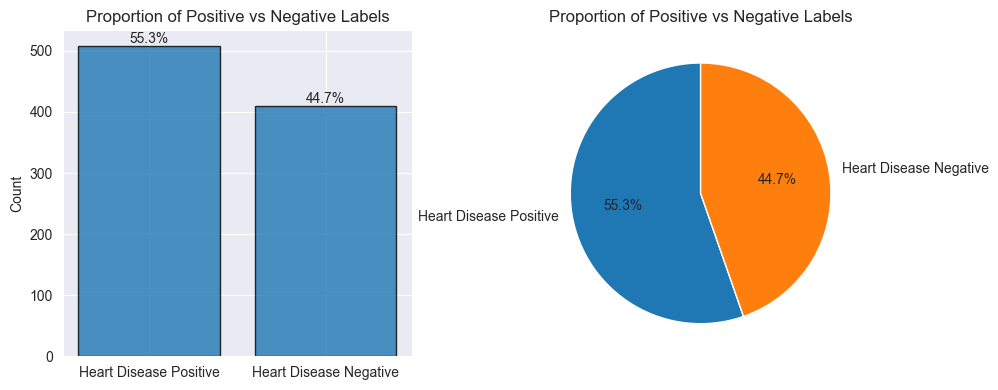

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
ax_bar = axes[0]
bar_data = df["HeartDisease"].value_counts()
ax_bar.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)
ax_bar.set_xticks([0, 1])
ax_bar.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])
for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax_bar.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax_bar.set_ylabel("Count")
ax_bar.set_title("Proportion of Positive vs Negative Labels")

# Pie chart
ax_pie = axes[1]
labels = ["Heart Disease Positive", "Heart Disease Negative"]
sizes = bar_data.values
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax_pie.set_title("Proportion of Positive vs Negative Labels")

plt.tight_layout()
plt.show()


distributions of numerical features

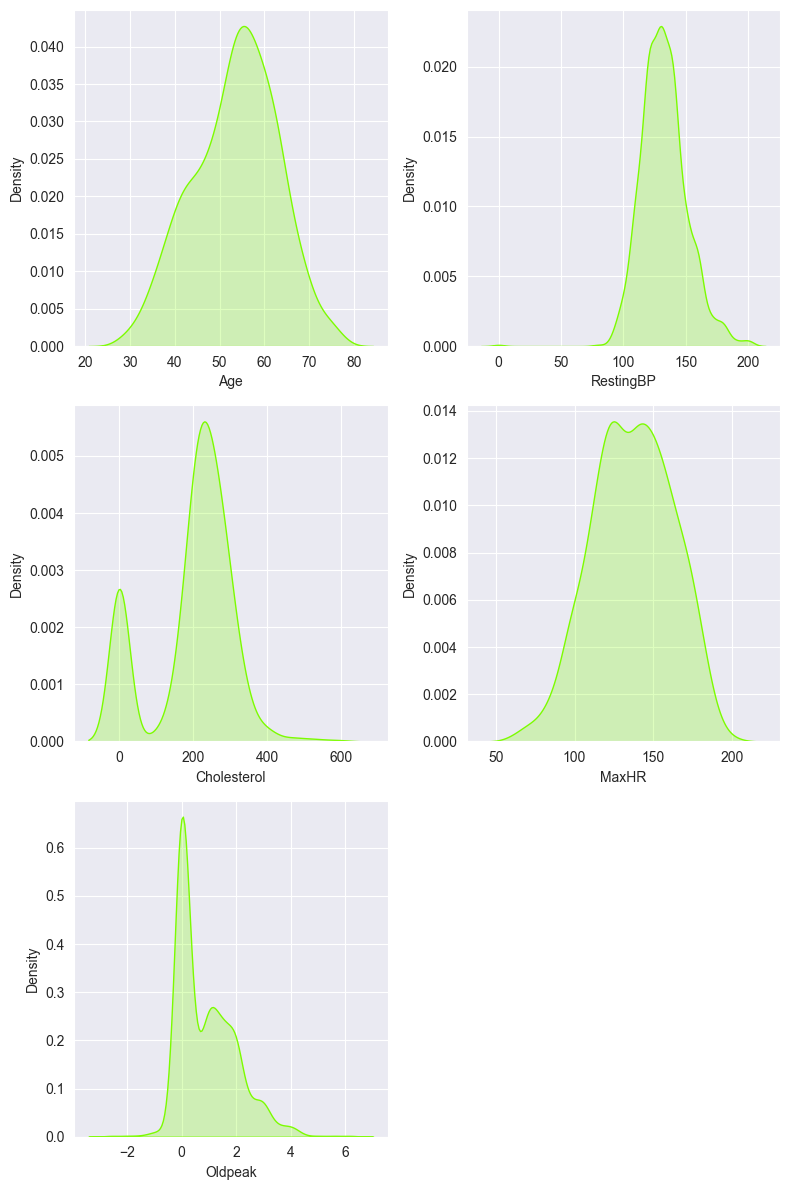

In [10]:
numerical_feature_names = numerical_features.columns.tolist()

num_features = len(numerical_feature_names)
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(3, 2, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for the feature
    sns.kdeplot(df[cont_feature], ax=ax_kde, fill=True, color="lawngreen", label="Data True Distribution")

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Numerical features and their relationship with Heart Disease

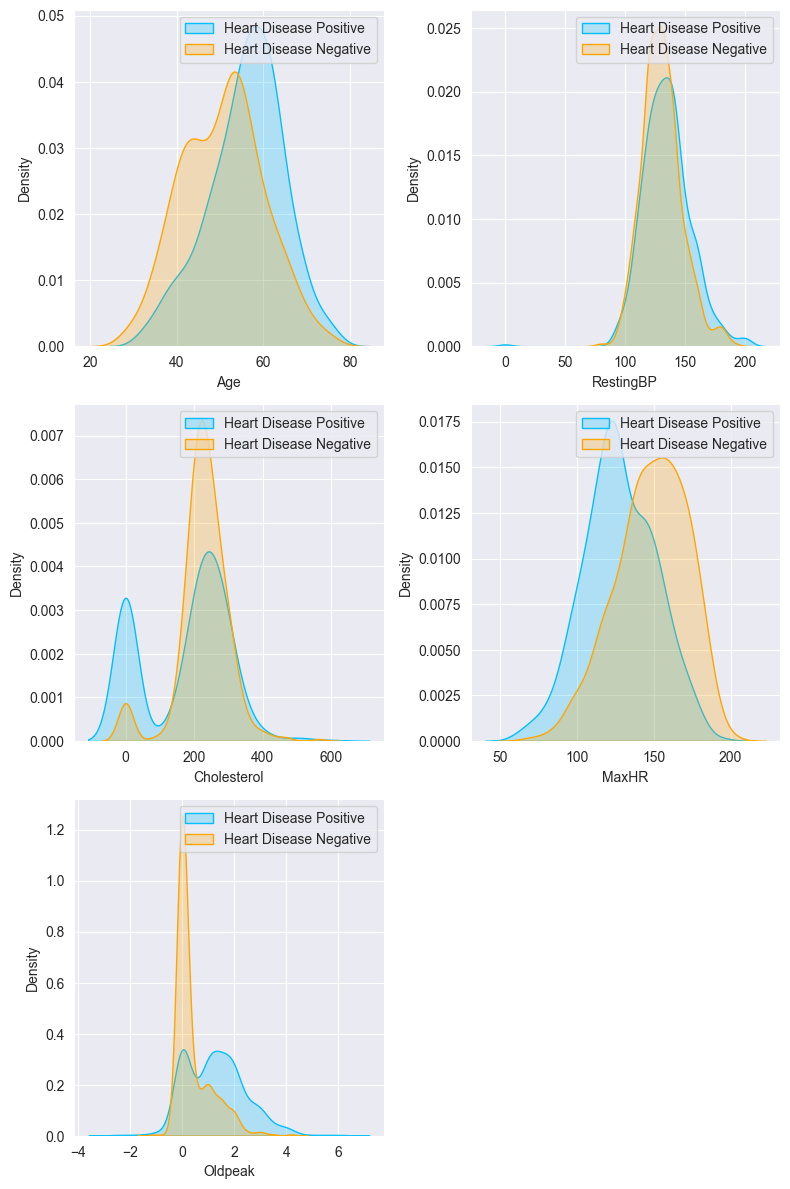

In [16]:
numerical_feature_names = numerical_features.columns.tolist()
positive = df[df["HeartDisease"] == 1]  # Subset of data for heart failure cases
negative = df[df["HeartDisease"] == 0]  # Subset of data for non-heart failure cases


num_features = len(numerical_feature_names)
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for heart failure positive cases
    sns.kdeplot(positive[cont_feature], ax=ax_kde, fill=True, color="deepskyblue", label="Heart Disease Positive")

    # Plot KDE for heart failure negative cases
    sns.kdeplot(negative[cont_feature], ax=ax_kde, fill=True, color="orange", label="Heart Disease Negative")

    ax_kde.legend()

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


compare mean of each feature for positive vs negative

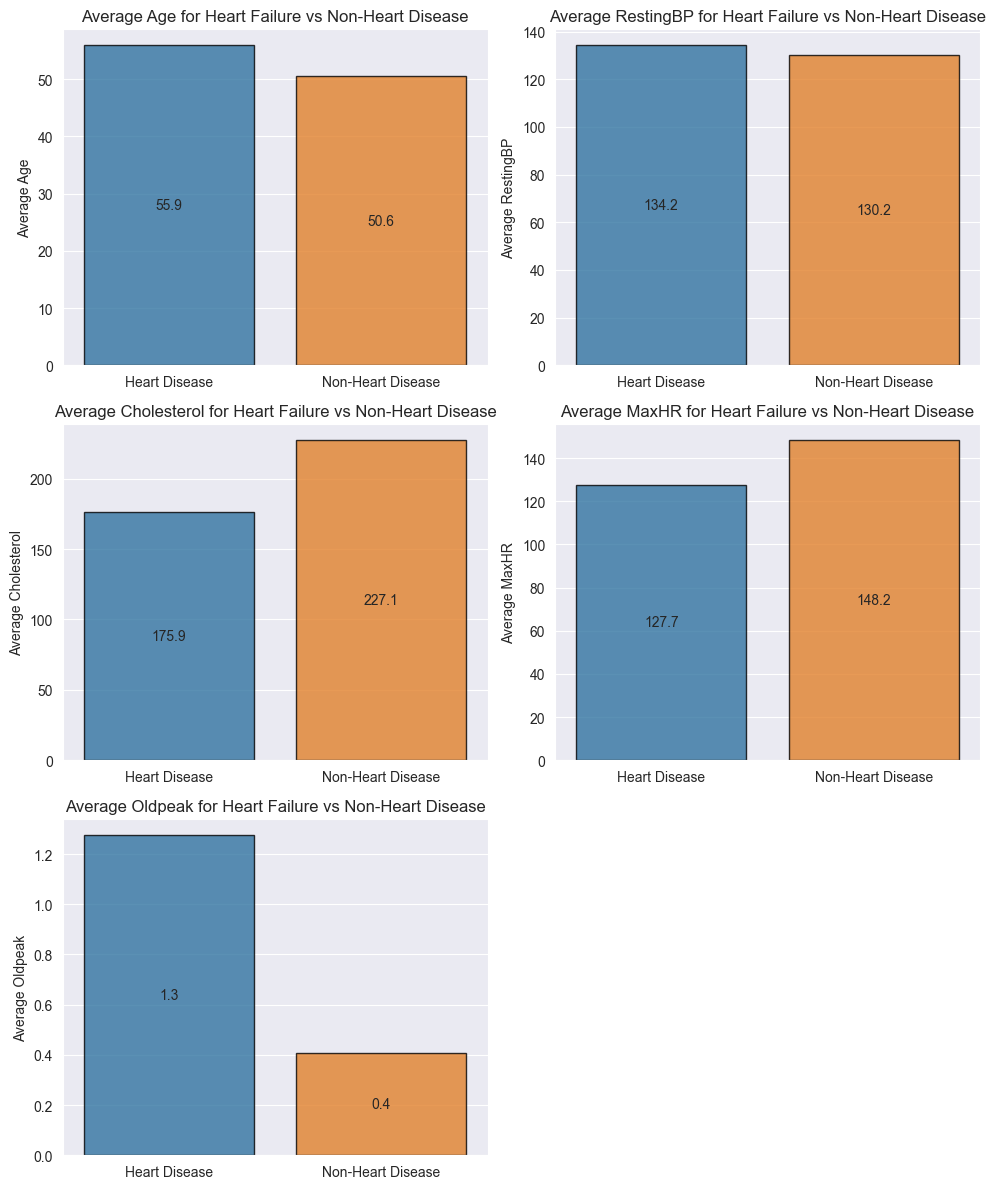

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Looping through each feature
for i, feature in enumerate(numerical_feature_names):
    row = i // 2  # Calculate the row index for the subplot
    col = i % 2  # Calculate the column index for the subplot

    avg_heart_failure = positive[feature].mean()
    avg_non_heart_failure = negative[feature].mean()

    # Creating the bar chart for the current feature
    ax = axes[row, col]
    # ax.bar(["Heart Disease", "Non-Heart Disease"], [avg_heart_failure, avg_non_heart_failure])
    sns.barplot(x=["Heart Disease", "Non-Heart Disease"], y=[avg_heart_failure, avg_non_heart_failure], ax=ax, edgecolor="black", alpha=0.8)
    ax.set_ylabel("Average " + feature)
    ax.set_title("Average " + feature + " for Heart Failure vs Non-Heart Disease")

    # Adding annotations to the bars
    ax.annotate(f"{avg_heart_failure:.1f}", xy=(0, avg_heart_failure/2), ha="center", va="center")
    ax.annotate(f"{avg_non_heart_failure:.1f}", xy=(1, avg_non_heart_failure/2), ha="center", va="center")

# Remove the empty subplot in the bottom right corner
fig.delaxes(axes[2, 1])

# Adjusting the layout and spacing
plt.tight_layout()

# Displaying the chart
plt.show()


It looks like cholesterol was set to 0 as a null value, because people can't actually have 0 cholesterol